In [4]:
# transformers is not preinstalled in google colab
# !pip install transformers

# weights and biases is not preinstalled in google colab
# !pip install wandb -q

# jupyter setup
# % commands are "jupyter notbook commands" - %matplotlib inline allows for inline plotting
%matplotlib inline
 
# import modules
import os 
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from sklearn import model_selection

import torch
import torch.nn as nn
import transformers
# import wandb
import matplotlib.pyplot as plt
import time
import random
from pathlib import Path
from typing import List, Optional, Tuple, Union

In [5]:
# !pip install wandb -qqq
import wandb
wandb.login()

True

In [6]:
# import zipfile
# with zipfile.ZipFile('final_patent.csv.zip', 'r') as zip_ref:
#     zip_ref.extractall()


In [7]:
# set parameters
parameter_dict = {
    'huggingface_model': 'bert-base-uncased', 
    'epochs' : 4,
    'batch_size': 5,
    'dropout_finetune': 0.2,
    'learning_rate_AdamW': 2e-5,
    'metadata_embedding_size': 128,
    'hidden_layer_size': 2048,
    'seed': 101
} 

In [8]:
model_name = f"{parameter_dict['huggingface_model']}-with-metadata-2hidden_layers"

In [10]:
wandb.init(project="SimranThesis", name=model_name, config=parameter_dict)

In [11]:
# Set up torch for colab
if torch.cuda.is_available():
  device = torch.device('cuda') # specify the GPU we want to use in torch
  print('Google made {} GPU available for this notebook.'.format(torch.cuda.device_count()))
  print('GPU type: {}'.format(torch.cuda.get_device_name()))
else:
  print('CPU must be used')
  device = torch.device("cpu")

Google made 2 GPU available for this notebook.
GPU type: Tesla V100-SXM2-32GB


In [12]:
import re
# function to remove all digits from the abstract
def clean_abstract(text):
    return re.sub(r"\d", "", text)

In [13]:
# sample_data_df = pd.read_csv(path_to_input.format('sample_data.csv'))
sample_data_df = pd.read_csv('final_patent.csv')
sample_data_df = sample_data_df.dropna()
sample_data_df = sample_data_df.reset_index(drop=True)
possible_labels = sample_data_df['cpc_code'].unique()

numerical_encoding_dict = {}
for index, possible_label in enumerate(possible_labels):
    numerical_encoding_dict[possible_label] = index

sample_data_df['cpc_class_numerical'] = sample_data_df['cpc_code'].replace(numerical_encoding_dict)

sample_data_df['text'] = sample_data_df['patent_title'].astype(str) + ' ' + sample_data_df['patent_abstract'].astype(str)
sample_data_df['text'] = sample_data_df['text'].apply(lambda x: x.lower())
sample_data_df['text'] = sample_data_df['text'].apply(clean_abstract)

# metadata: review year ids
sample_data_df['year'] = pd.to_datetime(sample_data_df['patent_date']).dt.year
year_dict = {k: k-sample_data_df['year'].min() for k in sample_data_df['year'].unique()}
sample_data_df['year_ids'] = sample_data_df['year'].replace(year_dict)

/scratch/slurm_tmpdir/job_22283538/ipykernel_496846/1490893273.py:2: DtypeWarning: Columns (1,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_data_df = pd.read_csv('final_patent.csv')


In [ ]:
sample_data_df.reset_index(inplace = True)
sample_data_df = sample_data_df[['patent_id', 'cpc_code', 'cpc_class_numerical', 'text', 'year', 'year_ids']]
# sample_data_df = sample_data_df_1
sample_data_df_1 = sample_data_df

In [ ]:
result = sample_data_df.groupby(['cpc_code', 'year']).head(30)
sample_data_df = result.reset_index(drop=True)
sample_data_df

,patent_id,cpc_code,cpc_class_numerical,text,year,year_ids
0,10000000,G01,0,coherent ladar using intra-pixel quadrature de...,2018,42
1,10000001,B29,1,injection molding machine and mold thickness c...,2018,42
2,10000002,B29,1,method for manufacturing polymer film and co-e...,2018,42
3,10000003,B29,1,method for producing a container from a thermo...,2018,42
4,10000004,B29,1,"process of obtaining a double-oriented film, c...",2018,42
...,...,...,...,...,...,...
167318,9982317,C13,115,systems and methods for acid recycle methods a...,2018,42
167319,9982386,D07,118,rope structure with improved bending fatigue a...,2018,42
167320,9994924,C13,115,method for the fractionation of lignocellulosi...,2018,42
167321,9994994,D07,118,hybrid rope hybrid rope () comprising a core e...,2018,42


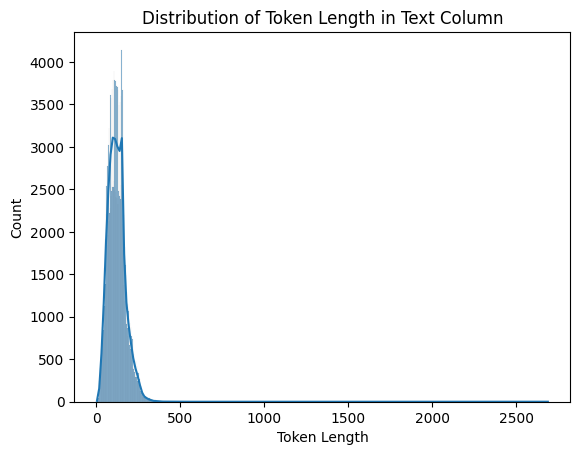

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming sample_data_df is your dataframe containing the 'text' column

token_lengths = sample_data_df['text'].apply(lambda x: len(x.split()))

sns.histplot(token_lengths, kde=True)
plt.xlabel('Token Length')
plt.ylabel('Count')
plt.title('Distribution of Token Length in Text Column')
plt.show()

In [ ]:
import pandas as pd

# Assuming sample_data_df is your dataframe containing the 'text' column

median_token_length = sample_data_df['text'].str.split().apply(lambda x: len(x)).median()

print("Median Token Length:", median_token_length)

Median Token Length: 118.0


In [ ]:
rd = pd.read_csv("abstract_title_text_RD.csv")
rd = rd[rd['language'] == 'en']

rd = rd.dropna()
rd = rd.reset_index(drop=True)

# metadata: review year ids
rd['year'] = pd.to_datetime(rd['date']).dt.year
year_dict = {k: k-rd['year'].min() for k in rd['year'].unique()}
rd['year_ids'] = rd['year'].replace(year_dict)

rd['text_all'] = rd['abstract'].apply(lambda x: x.lower())
rd['text_all'] = rd['text_all'].apply(clean_abstract)
rd['text_all'] = rd['text_all'].str.rsplit('.', 1).str[0]

# test_data = rd

rd = rd.dropna()
rd = rd.sample(frac=6, replace=True)
rd = rd.reset_index(drop=True)

rd = rd.iloc[:sample_data_df.shape[0]]

# tranform data to lists
feature_text_distance, feature_year_distance = rd['text_all'].to_list(), rd['year_ids'].to_list()
# feature_text_target, feature_year_target = test_data['text_all'].to_list(), test_data['year_ids'].to_list()

/scratch/slurm_tmpdir/job_22283538/ipykernel_496846/3984927391.py:14: FutureWarning: In a future version of pandas all arguments of StringMethods.rsplit except for the argument 'pat' will be keyword-only.
  rd['text_all'] = rd['text_all'].str.rsplit('.', 1).str[0]


In [ ]:
sample_data_df.shape

(167323, 6)

In [ ]:
rd.shape

(167323, 10)

In [ ]:
class BertClassificationMetadata(transformers.BertPreTrainedModel):
    def __init__(self, config, num_year_ids, metadata_embedding_size, hidden_layer_size, dropout_fine_tune):
        super().__init__(config)
        self.bert = transformers.BertModel(config)
        self.num_labels = config.num_labels
        self.config = config

        self.dropout = nn.Dropout(dropout_fine_tune)
        self.embedding_year = nn.Embedding(num_year_ids, metadata_embedding_size) #32, 128       
        self.layer_normalizer = nn.LayerNorm(768 + metadata_embedding_size) # 896
        self.fc1_hidden = nn.Linear(768 + metadata_embedding_size, hidden_layer_size)#896 , 2048
        self.fc2_hidden = nn.Linear(hidden_layer_size, hidden_layer_size)#2048 , 2048
        self.fc_classifier = nn.Linear(hidden_layer_size, config.num_labels)

        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        year_ids: Optional[torch.Tensor] = None,
    ) -> Union[Tuple[torch.Tensor], transformers.modeling_outputs.SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        year_embedding = self.embedding_year(year_ids)

        pooled_bert_output = outputs[1]
        
        # print(pooled_bert_output.size(), year_embedding.size())
        
        # concat
        input_classification_head = torch.cat((pooled_bert_output, year_embedding), dim=1)#32, 1024

        # fc1
        input_fc1_hidden = self.dropout(self.layer_normalizer(input_classification_head))#32, 1024
        output_fc1_hidden = self.fc1_hidden(input_fc1_hidden)# 32, 768

        # fc2
        input_fc2_hidden = torch.relu(self.dropout(output_fc1_hidden))
        output_fc2_hidden = self.fc2_hidden(input_fc2_hidden) #32, 768

        # logit classifier
        input_fc_classifier = torch.relu(self.dropout(output_fc2_hidden))
        logits = self.fc_classifier(input_fc_classifier)

        # loss
        # loss_fct = nn.CrossEntropyLoss()
        # loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        else:
            loss = None
            
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
# train validation test hold out split
# test size
test_size = 0.2

# validation size
val_size = 0.2

# training size
train_size = 0.6

training_data, test_data = sklearn.model_selection.train_test_split(sample_data_df, test_size=test_size, random_state=parameter_dict['seed'])
training_data, validation_data = sklearn.model_selection.train_test_split(training_data, test_size=val_size/(1-test_size), random_state=parameter_dict['seed'])
# del all_data_df
# tranform data to lists
feature_text_train, feature_year_train, labels_train = training_data['text'].to_list(), training_data['year_ids'].to_list(), training_data['cpc_class_numerical'].to_list()
feature_text_validation, feature_year_validation, labels_validation = validation_data['text'].to_list(), validation_data['year_ids'].to_list(), validation_data['cpc_class_numerical'].to_list()
feature_text_test, feature_year_test, labels_test = test_data['text'].to_list(), test_data['year_ids'].to_list(), test_data['cpc_class_numerical'].to_list()


In [25]:
from tqdm import tqdm
median_token_length = int(median_token_length)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def fast_encode(texts, tokenizer, chunk_size=512, maxlen=400):
    input_ids = []
    attention_mask = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i + chunk_size]
        encs = tokenizer.batch_encode_plus(
            text_chunk,
            max_length=maxlen,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )        
        input_ids.append(encs['input_ids'])
        attention_mask.append(encs['attention_mask'])

    return {
        'input_ids': torch.cat(input_ids, dim=0).squeeze(),
        'attention_mask': torch.cat(attention_mask, dim=0).squeeze()
    }

In [26]:
feature_text_train = fast_encode(feature_text_train, tokenizer)
feature_text_validation = fast_encode(feature_text_validation, tokenizer)
feature_text_test = fast_encode(feature_text_test, tokenizer)
feature_text_target = fast_encode(feature_text_distance, tokenizer)

100%|██████████| 327/327 [07:41<00:00,  1.41s/it]


In [27]:
# import pickle

# # Save the variables
# with open('tokens_150.pickle', 'wb') as f:
#     pickle.dump((feature_text_train, feature_text_validation, feature_text_test, feature_text_target), f)


In [28]:
# import pickle

# # Restore the variables
# with open('tokens_150.pickle', 'rb') as f:
#     feature_text_train, feature_text_validation, feature_text_test, feature_text_target = pickle.load(f)


In [29]:
len(labels_train)

100393

In [30]:
# # Setup the pre-treained BERT Tokenizer
# bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# # Apply the tokenizer to the datasets
# feature_text_train = bert_tokenizer(feature_text_train, padding='max_length', max_length=median_token_length, truncation =True, return_tensors='pt')
# feature_text_validation = bert_tokenizer(feature_text_validation, padding='max_length', max_length=median_token_length, truncation =True, return_tensors='pt')
# feature_text_test = bert_tokenizer(feature_text_test, padding='max_length', max_length=median_token_length, truncation =True, return_tensors='pt')
# feature_text_target = bert_tokenizer(feature_text_distance, padding='max_length', max_length=median_token_length, truncation =True, return_tensors='pt')

In [31]:
# data loader for transformers
class AttributeDataset(torch.utils.data.Dataset):
  def __init__(self, tokenized_text: torch.Tensor, year_ids, labels):
    self.tokenized_features = tokenized_text
    self.year_ids = torch.tensor(year_ids)
    self.labels = torch.tensor(labels)
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.tokenized_features.items()}
    item['year_ids'] = self.year_ids[idx]
    item['labels'] = self.labels[idx]
    return item
  
  def __len__(self):
    return len(self.labels)

train_torch = AttributeDataset(feature_text_train, feature_year_train, labels_train)
validation_torch = AttributeDataset(feature_text_validation, feature_year_validation, labels_validation)
test_torch = AttributeDataset(feature_text_test, feature_year_test, labels_test)

In [32]:
# Setup the pre-treained BERT Tokenizer
# bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# data loader for transformers
class AttributeDataset(torch.utils.data.Dataset):
  def __init__(self, tokenized_text: torch.Tensor, year_ids):
    self.tokenized_features = tokenized_text
    self.year_ids = torch.tensor(year_ids)
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.tokenized_features.items()}
    item['year_ids'] = self.year_ids[idx]
    return item

  def __len__(self):
    return rd.shape[0]

target_torch = AttributeDataset(feature_text_target, feature_year_distance)
target_dataloader = torch.utils.data.DataLoader(target_torch, batch_size=parameter_dict['batch_size'])


In [33]:
# Load the pretrained BERT model and push it to the GPU memory

#bert_classification_model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(numerical_encoding_dict))
bert_classification_model = BertClassificationMetadata.from_pretrained('bert-base-uncased', num_labels=len(numerical_encoding_dict), num_year_ids = max(year_dict.keys()), metadata_embedding_size=parameter_dict['metadata_embedding_size'], hidden_layer_size=parameter_dict['hidden_layer_size'], dropout_fine_tune=parameter_dict['dropout_finetune'])

# model to GPU
bert_classification_model.to(device)

# Define the data loader for batching, batch size 16 seems to work well
# (higher would cause memory overflow problems on the GPU)
train_data_loader = torch.utils.data.DataLoader(train_torch, batch_size=parameter_dict['batch_size'], shuffle=True)
validation_data_loader = torch.utils.data.DataLoader(validation_torch, batch_size=parameter_dict['batch_size'], shuffle=True)
number_of_batches = len(train_data_loader)
print(f'Number of Batches: {number_of_batches}')

# Setup the ADAM optimizer with generic parameters.
optimizer = torch.optim.AdamW(bert_classification_model.parameters(), lr=parameter_dict['learning_rate_AdamW'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertClassificationMetadata: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertClassificationMetadata from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertClassificationMetadata from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertClassificationMetadata were not initialized from the model checkpoint at bert-base-u

Number of Batches: 20079


In [34]:
# milestones
def training_milestone(number_of_milestones, number_of_batches):
  batches_per_milestone = (number_of_batches-1)/number_of_milestones
  milestone_list = [int(x*batches_per_milestone) for x in range(1, number_of_milestones)]
  milestone_list.append(number_of_batches-1)
  return milestone_list

training_milestones = training_milestone(16, number_of_batches)

# validation
validation_milestones = training_milestone(4, number_of_batches)

In [35]:
def mmd_loss(hidden_states_source, hidden_states_target, sigma):
    # Compute the mean embeddings of the source and target domains
    mean_source = torch.mean(hidden_states_source, dim=0)
    mean_target = torch.mean(hidden_states_target, dim=0)

    # Compute the MMD between the source and target domains
    mmd = 0
    for i in range(hidden_states_source.shape[0]):
        for j in range(hidden_states_target.shape[0]):
            dist = torch.sum(torch.square(hidden_states_source[i] - hidden_states_target[j]))
            mmd += torch.exp(-dist / (2 * sigma ** 2))

    return mmd / (hidden_states_source.shape[0] * hidden_states_target.shape[0])


In [36]:
len(train_torch)

100393

In [37]:
len(validation_data)

33465

In [ ]:
# start timer
start_time = time.time()
# initialize training
bert_classification_model.train()
# first loss to high values to not save model
sum_of_val_loss_min = 9999
# iterator for the number of validation runs
val_run_iter = 0

print(''.join([25*'-', ' Start Training ', 25*'-']))
print(''.join([25*'-', '----------------', 25*'-']))
alpha = 0.01
sigma = 1.0
for epoch in range(parameter_dict['epochs']):
    for batch_iter, (batch_source, batch_target) in enumerate(zip(train_data_loader, target_dataloader)):
        # batch to GPU
        # text
        input_ids_source, attention_mask_source, year_ids_source, labels_source = batch_source['input_ids'].to(device), batch_source['attention_mask'].to(device), batch_source['year_ids'].to(device), batch_source['labels'].to(device)
        input_ids_target, attention_mask_target, year_ids_target = batch_target['input_ids'].to(device), batch_target['attention_mask'].to(device), batch_target['year_ids'].to(device)
        # after each updateing set optimzer gradient to zero
        optimizer.zero_grad()
        
        outputs_source = bert_classification_model(input_ids=input_ids_source, attention_mask=attention_mask_source, year_ids=year_ids_source, labels = labels_source)
        outputs_target = bert_classification_model(input_ids=input_ids_target, attention_mask=attention_mask_target, year_ids=year_ids_target)
        hidden_states_target = outputs_target.hidden_states[0]
        hidden_states_source = outputs_source.hidden_states[0]
        
        mmd_loss_value = mmd_loss(hidden_states_source, hidden_states_target, sigma)
        # Compute the distance between the source and target distributions
        target_dist = torch.mean(torch.exp(hidden_states_target), dim=0)
        source_dist = torch.mean(torch.exp(hidden_states_source), dim=0)
        
        """
        the code computes the source and target distributions by taking the mean of the exponential values of the hidden states. 
        The exponential function is used to convert the hidden states into a probability distribution over the vocabulary.
        The mean is computed along the batch dimension, resulting in a single probability distribution for each domain.
        """
        distance = torch.sum(torch.abs(source_dist - target_dist))
        """
        Finally, the code computes the distance between the source and target distributions using the L1 distance. 
        The L1 distance is the sum of the absolute differences between the corresponding elements of the two distributions. 
        This distance is used as a measure of how different the two domains are from each other. 
        The goal of domain adaptation is to minimize this distance, typically by adjusting the model's parameters to make it more robust to domain shift.
        """

        # total_loss = outputs_source[0] + alpha * distance
        
        """
        The MMD loss measures the difference between the source and target domains in terms of their embeddings in a high-dimensional space defined by the Gaussian kernel.
        The goal of the loss is to minimize this difference, which encourages the model to learn embeddings that are similar across domains.
        """
        
        # Compute the total loss as a linear combination of the CE and MMD losses
        loss = outputs_source[0] + alpha * mmd_loss_value
        # backpropergation
        loss.backward() 
        optimizer.step()

        # foward_pass_output['logits'] logits is the classifcation output
        # before the softmax is applied --> the prediction is always the highest
        # one.

        # logging
        training_log_dict = {
            'training_loss': torch.mean(loss)
            }

        
    # progress reporting 
    if batch_iter in training_milestones:
      # save memory by not calculating a gradient
      with torch.no_grad():
        print(f'Epoch: {epoch}\tBatch: {batch_iter}\tTrain-Loss: {torch.mean(loss)}')
    
    # Validation:
    # For each epoch I evaluate the model on a validation set twice. The model with 
    # the lowest (batch-wise sum) cross-entropy loss on the validation set is chosen.


    if batch_iter in validation_milestones:
      # set to evaluation (stop dropout)
      bert_classification_model.eval()
      print(''.join([25*'-', '----------------', 25*'-']))
      print(f'Validation Run {val_run_iter} (Epoch {epoch}):')

      # initaile selection cretarion.
      sum_of_val_loss = 0
      num_of_correct_predictions = 0
      # loop over validation loss
      for val_batch in validation_data_loader:
        # permit pytroch to save gradients for the validation data since no 
        # backpropergation is not needed (save memory)

        with torch.no_grad():
         
          # batch to GPU
          # text
          batch_text_inputids = val_batch['input_ids'].to(device)
          batch_text_attention_mask = val_batch['attention_mask'].to(device)

          # metadata
          batch_yearids = val_batch['year_ids'].to(device)

          #labels
          labels = val_batch['labels'].to(device)
    
          # forward pass
          forward_pass_output = bert_classification_model(input_ids=batch_text_inputids, attention_mask=batch_text_attention_mask, year_ids=batch_yearids, labels=labels)
          loss = forward_pass_output[0]

          # add batch specific loss
          sum_of_val_loss += loss

          # accuracy
          num_of_correct_predictions += torch.sum(forward_pass_output['logits'].argmax(axis=1) == labels)

      # log the loss and precision of the model

      mean_loss_val = sum_of_val_loss/len(validation_data)
      accuracy_val = num_of_correct_predictions/len(validation_data)
      validation_log_dict = {
          'validation_loss': sum_of_val_loss/len(validation_data),
          'validation_accuracy': num_of_correct_predictions/len(validation_data)
        }

      # print validation results
      print(f'\t{val_run_iter}\n\t Val-Loss: \t{mean_loss_val}\n\t Val-Accu: \t{accuracy_val}')

      # update iter
      val_run_iter += 1
      # save the model if loss improved
      if (sum_of_val_loss<sum_of_val_loss_min):
        sum_of_val_loss_min = sum_of_val_loss
        torch.save(bert_classification_model, f'{model_name}.pt')
        print(''.join(['!'*25, ' New best Model ', '!'*25]))
      
      # print validation loss
      print(''.join([25*'-', '----------------', 25*'-']))
      print(f'Resume Training:')
      # set to training (activate dropout)
      bert_classification_model.train()
        
      # log validation
      wandb.log(validation_log_dict)

    # log training  
    wandb.log(training_log_dict)

# end training           
bert_classification_model.eval() 
print('The Training took: ',time.time()-start_time, 'Seconds')
# del bert_classification_model
    

------------------------- Start Training -------------------------
------------------------------------------------------------------


In [ ]:
len(target_dataloader)

In [ ]:
# loading the fine tuned model chosen on the validation set
# classification_model = torch.load((f'{model_name}.pt'), map_location=torch.device(device))

In [ ]:
rd = pd.read_csv("abstract_title_text_RD.csv")
rd = rd[rd['language'] == 'en']

rd = rd.dropna()
rd = rd.reset_index(drop=True)

# metadata: review year ids
rd['year'] = pd.to_datetime(rd['date']).dt.year
year_dict = {k: k-rd['year'].min() for k in rd['year'].unique()}
rd['year_ids'] = rd['year'].replace(year_dict)

rd['text_all'] = rd['abstract'].apply(lambda x: x.lower())
rd['text_all'] = rd['text_all'].apply(clean_abstract)
rd['text_all'] = rd['text_all'].str.rsplit('.', 1).str[0]

# test_data = rd

rd = rd.dropna()
# rd = rd.sample(frac=10, replace=True)
rd = rd.reset_index(drop=True)

# tranform data to lists
feature_text_target, feature_year_target = rd['text_all'].to_list(), rd['year_ids'].to_list()

In [ ]:
# Setup the pre-treained BERT Tokenizer
# bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
feature_text_target = fast_encode(feature_text_target, tokenizer)
# Apply the tokenizer to the datasets
# feature_text_target= bert_tokenizer(feature_text_target, padding='max_length', max_length = median_token_length, truncation =True, return_tensors='pt')

# data loader for transformers
class AttributeDataset(torch.utils.data.Dataset):
  def __init__(self, tokenized_text: torch.Tensor, year_ids):
    self.tokenized_features = tokenized_text
    self.year_ids = torch.tensor(year_ids)
  
  def __getitem__(self, idx):
    item = {key: val[idx] for key, val in self.tokenized_features.items()}
    item['year_ids'] = self.year_ids[idx]
    return item

  def __len__(self):
    return rd.shape[0]

target_torch = AttributeDataset(feature_text_target, feature_year_target)
target_dataloader = torch.utils.data.DataLoader(target_torch, batch_size=parameter_dict['batch_size'])


In [ ]:
# ignore dropout for testing
bert_classification_model.eval()

# timer
start_time = time.time()

# load test data
test_data_loader = torch.utils.data.DataLoader(test_torch, batch_size=parameter_dict['batch_size'])

# numpy arrays to store predictions and true labels.
predictions = np.array([])
true_labels = np.array([])

# train the model
for test_batch in test_data_loader:

    # I do not need gradient
    with torch.no_grad():

        # batch to GPU
        # text
        batch_text_inputids = test_batch['input_ids'].to(device)
        batch_text_attention_mask = test_batch['attention_mask'].to(device)

        # metadata
        batch_yearids = test_batch['year_ids'].to(device)

        #labels
        labels = test_batch['labels'].to(device)

        # forward pass
        foward_pass_output = bert_classification_model(input_ids=batch_text_inputids, attention_mask=batch_text_attention_mask, year_ids=batch_yearids, labels=labels)
        
        # foward_pass_output['logits'] logits is the classifcation output
        # before the softmax is applied --> the prediction is always the highest
        # one.
        predictions = np.append(predictions, foward_pass_output['logits'].argmax(axis=1).cpu().numpy())

        # since I shuffle the batche
        true_labels = np.append(true_labels, labels.cpu().numpy())

print('Out-of-sample predictions took: ',time.time()-start_time, 'Seconds')

In [ ]:
# !pip install tabulate

In [ ]:
# model evaluations
import tables
Path((f'{model_name}')).mkdir(parents=True, exist_ok=True)

# tests
test_statistic = dict()
test_statistic['accuracy'] = sklearn.metrics.accuracy_score(true_labels, predictions)
test_statistic['recall'] = sklearn.metrics.recall_score(true_labels, predictions, average='macro')
test_statistic['precison'] = sklearn.metrics.precision_score(true_labels, predictions, average='macro')
test_statistic['f1_score'] = sklearn.metrics.f1_score(true_labels, predictions, average='macro')

# logging measures
test_statistics_table = wandb.Table(columns=list(test_statistic.keys()), data=[list(test_statistic.values())])
wandb.log({"test_table" : test_statistics_table})

# # to df and safe
scores_df = pd.DataFrame.from_dict(test_statistic, orient='index').reset_index().rename(columns={'index': 'measure', 0: 'score'})
scores_df.to_csv((f'{model_name}/measures_{model_name}_test.csv'), index=False)
print(f'Evaluation Measures Test Set:\n{scores_df.to_markdown()}\n')

# logging confusion matrix
wandb.log({"confusion_matrix_test" : wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=predictions, class_names=list(numerical_encoding_dict.keys()))})

# # get the confusion matrix
# confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, predictions)
# confusion_matrix_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix.astype('int'), display_labels=numerical_encoding_dict.keys())
# confusion_matrix_plot.plot(values_format='.0f', xticks_rotation='vertical')
# print('Confusion Matrix Test Set:')
# plt.tight_layout()
# plt.savefig((f'{model_name}/confusion_matirx_{model_name}_test.png'), bbox_inches='tight', dpi=1080)

In [ ]:
# predictions

In [ ]:
# ignore dropout for prediction
bert_classification_model.eval()

# timer
start_time = time.time()

# numpy arrays to store predictions and true labels.
predictions = np.array([])
true_labels = np.array([])

# train the model
for target_batch in target_dataloader:

    # I do not need gradient
    with torch.no_grad():

        # batch to GPU
        # text
        batch_text_inputids = target_batch['input_ids'].to(device)
        batch_text_attention_mask = target_batch['attention_mask'].to(device)

        # metadata
        batch_yearids = target_batch['year_ids'].to(device)

        # forward pass
        foward_pass_output = bert_classification_model(input_ids=batch_text_inputids, attention_mask=batch_text_attention_mask, year_ids=batch_yearids)
        
        # foward_pass_output['logits'] logits is the classifcation output
        # before the softmax is applied --> the prediction is always the highest
        # one.
        predictions = np.append(predictions, foward_pass_output['logits'].argmax(axis=1).cpu().numpy())

print('predictions took: ',time.time()-start_time, 'Seconds')

In [ ]:
with open('predictions_400_tokens.txt', 'w') as file:
    for item in predictions:
        file.write("%s\n" % item)

In [ ]:
predictions_list = list(map(int, predictions))


In [ ]:
matched_keys = []

for prediction in predictions_list:
    for key, value in numerical_encoding_dict.items():
        if value == prediction:
            matched_keys.append(key)
            break

In [ ]:
len(predictions_list)



In [ ]:
rd['Predicted_Label'] = matched_keys

In [ ]:
rd_predicted = rd[['rdid', 'text_all', 'year', 'Predicted_Label']]

In [ ]:
rd_predicted.to_csv("rd_predicted_400.csv")

In [ ]:
rd_predicted

In [ ]:
len(rd_predicted.Predicted_Label.value_counts())